In [1]:
# 自作モジュールの参照先を上書き
import sys
parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride


import time
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.optim import Adam

from module.lino_module.preprocess import mode_of_freq, tde_dataset_wm, select_device
from module.lino_module.model import TransformerModel
from module.lino_module.training import training
from module.lino_module.ploter import learning_plot, confirmation, to_time_series,\
                                        confirmation_plot

# 乱数固定
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データセットの準備

In [10]:
data = pd.read_csv('../data/sales_train.csv')
data = mode_of_freq(data).item_cnt_day
seq = 7
d_model = 24
dilation = 2
src_tgt_seq = (int(seq * 0.7),int(seq * 0.7))
step_num = seq - int(seq * 0.7)
scaler = StandardScaler

kwrgs = {'data': data,
         'seq': seq,
         'd_model': d_model,
         'dilation': dilation,
         'src_tgt_seq': src_tgt_seq,
         'step_num': step_num,
         'daily': False,
         'weekly': True,
         'weekly_num': False,
         'monthly': True,
         'scaler': scaler,
         'batch_size': 64,
         'train_rate': 0.9}

train, test = tde_dataset_wm(**kwrgs)

## Transformerモデルの準備

In [11]:
# device = select_device() # mps では Transformer の attention でエラー
device = torch.device('cpu')

cat_dim = kwrgs['daily'] + kwrgs['weekly'] + kwrgs['weekly_num'] + kwrgs['monthly']
dim = d_model * (cat_dim + 1)

# モデルと損失関数
transformer = TransformerModel(d_model=dim, nhead=8, device=device).to(device)
# criterion = RMSELoss()  # 論文ではRMSELoss
criterion = nn.MSELoss().to(device)

# 学習率その他は論文の値を参考
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
optimizer = Adam(transformer.parameters(), lr=1e-5, betas=(0.95, 0.98), eps=10e-9)

## 訓練

In [12]:
epochs = 100
training_kwrgs = {'model': transformer,
                  'train': train,
                  'test': test,
                  'device': device,
                  'criterion': criterion,
                  'optimizer': optimizer,
                  'epochs': epochs,
                  'verbose': 10,
                  'center': 50}
transformer, loss_pack = training(**training_kwrgs)
train_loss, validation_loss, test_loss = loss_pack

--------------------- start ----------------------
                     epoch_0                      
train_loss:  1.0961 | validation_loss:  1.1345 | test_loss:  0.9825
                     epoch_10                     
train_loss:  0.5979 | validation_loss:  0.5035 | test_loss:  0.3135
                     epoch_20                     
train_loss:  0.4659 | validation_loss:  0.3787 | test_loss:  0.2212
                     epoch_30                     
train_loss:  0.4034 | validation_loss:  0.3229 | test_loss:  0.1813
                     epoch_40                     
train_loss:  0.3703 | validation_loss:  0.2876 | test_loss:  0.1716
                     epoch_50                     
train_loss:  0.3449 | validation_loss:  0.2603 | test_loss:  0.1532
                     epoch_60                     
train_loss:  0.3089 | validation_loss:  0.236 | test_loss:  0.1465
                     epoch_70                     
train_loss:  0.2826 | validation_loss:  0.219 | test_loss:  0.1426

## 訓練データ損失と検証データ損失

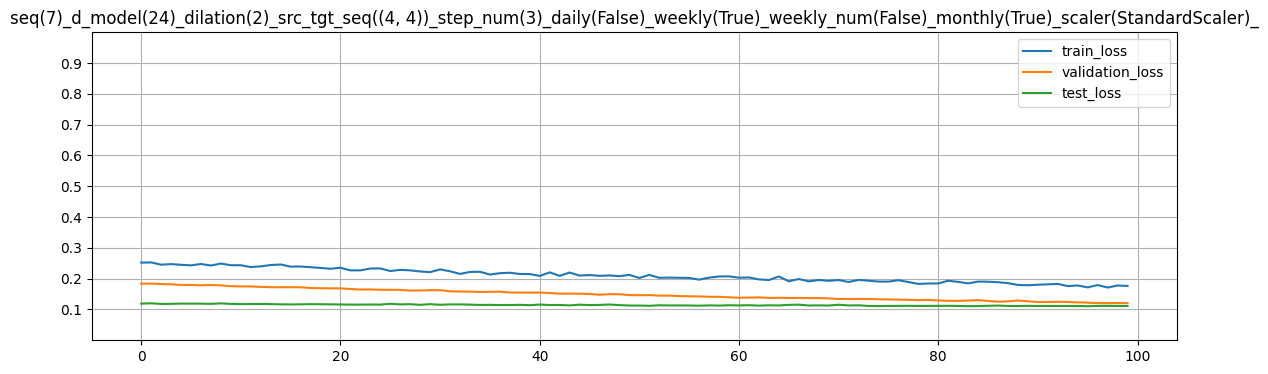

In [9]:
# ファイル名の作成
name = ''
for key, value in kwrgs.items():
    if key=='data':
        pass
    elif key=='scaler':
        name += f'{key}({value.__name__})_'
    else:
        name += f'{key}({value})_'

img_path = './img_wm/'
figsize = (14, 4)
saving = True
learning_plot(train_loss, validation_loss, test_loss,  img_path, name, scaler, figsize, saving)

## 訓練データとテストデータで予測

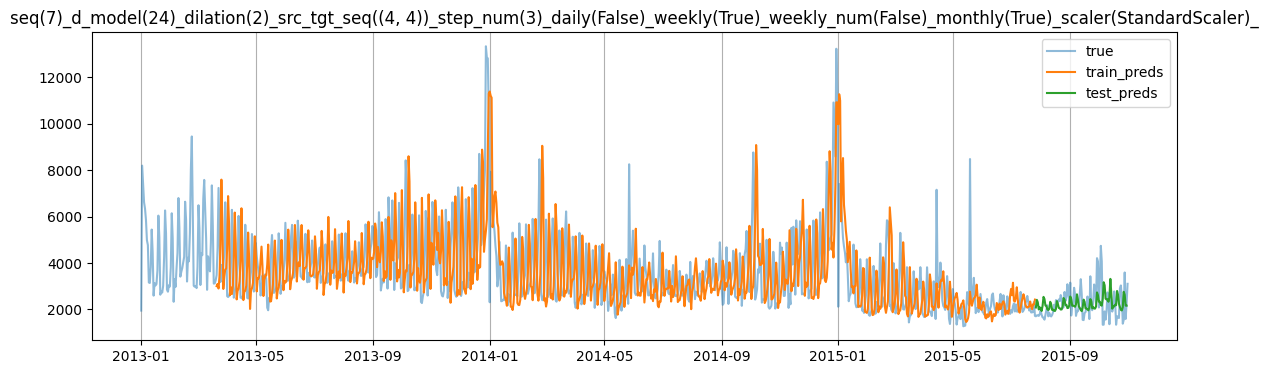

In [8]:
figsize = (14, 4)
train_preds, test_preds = confirmation(transformer, train, test, device)
train_time_series, test_time_series, original = to_time_series(data, train_preds, test_preds, scaler, d_model, dilation, seq)
confirmation_plot(train_time_series, test_time_series, original, img_path, name, figsize, saving)

### 以下は訓練のために作成したクラスおよび関数

In [ ]:
import time
import datetime
import math

import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from typing import Tuple


class TransformerModel(nn.Module):
    """Trasnsormer for Time Series
        参考論文: https://arxiv.org/abs/2001.08317
    """
    def __init__(self, d_model: int, nhead: int, device):
        super(TransformerModel, self).__init__()

        self.positional = PositionalEncoding(d_model)
        self.device = device

        encoder_layer = nn.TransformerEncoderLayer(
                                                d_model,
                                                nhead,
                                                dropout=0.2,
                                                batch_first=True
                                                )
        self.transformer_encoder = nn.TransformerEncoder(
                                                    encoder_layer,
                                                    num_layers=4
                                                    )

        decoder_layer = nn.TransformerDecoderLayer(
                                                d_model,
                                                nhead,
                                                dropout=0.2,
                                                batch_first=True
                                                )
        self.transformer_decoder = nn.TransformerDecoder(
                                                decoder_layer,
                                                num_layers=4
                                                )
        self.linear = nn.Linear(d_model, 1)

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        # Decoder用のtgt_maskを作成
        _, tgt_seq, _ = tgt.shape
        tgt_mask = _generate_mask(tgt_seq)   # A-look ahead mask

        # Positional Encoding
        src = self.positional(src)
        # Encoder
        memory = self.transformer_encoder(src)
        # Decoder
        output = self.transformer_decoder(tgt, memory, tgt_mask.to(self.device))
        # 線形変で出力の形状へ
        pred = self.linear(output)
        return pred


def _generate_mask(tgt_seq: int) -> Tensor:
    """デコーダ入力用の Self Attention用のマスクを作成"""
    inf_mask = torch.ones(tgt_seq, tgt_seq) * float('-inf')
    tgt_mask = torch.triu(inf_mask, diagonal=1)
    return tgt_mask


class PositionalEncoding(nn.Module):
    """PositionalEnoder"""
    def __init__(self, d_model: int, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[: x.size(0), :]
        return x


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, y, t):
        return torch.sqrt(self.mse(y, t))


def training(model: object,
             train: DataLoader,
             test: DataLoader,
             device: torch.device,
             criterion: object,
             optimizer: object,
             epochs: int,
             verbose=10,
             center=80) -> Tuple[object, Tensor, Tensor]:
    """訓練用関数"""
    train_loss = []
    validation_loss = []
    test_loss = []
    print(' start '.center(center, '-'))
    start_point = time.time()
    for epoch in range(epochs):
        epoch_point = time.time()
        train_epoch_loss = []
        validation_epoch_loss = []

        cache = None
        for i, pack in enumerate(train):
            src, tgt, y = [content.to(device) for content in pack]
            # モデル訓練
            if i == 0:
                pass
            else:
                # キャッシュから１バッチ前のデータで訓練
                cached_src, cached_tgt, cached_y = cache
                model.train()
                optimizer.zero_grad()
                output = model(cached_src, cached_tgt)
                loss = criterion(output.squeeze(), cached_y)
                train_epoch_loss.append(loss.item())
                # 勾配計算
                loss.backward()
                optimizer.step()
            # モデル評価
            model.eval()
            output = model(src, tgt)
            loss = criterion(output.squeeze(), y)
            validation_epoch_loss.append(loss.item())
            # データをキャッシュに保存して次回の訓練データにする
            cache = (src, tgt, y)
        
        test_epoch_loss = []
        for pack in test:
            src, tgt, y = [content.to(device) for content in pack]
            model.eval()
            output = model(src, tgt)
            loss = criterion(output.reshape(-1), y.reshape(-1))
            test_epoch_loss.append(loss.item())

        validation_loss.append(validation_epoch_loss)
        train_loss.append(train_epoch_loss)
        test_loss.append(test_epoch_loss)

        if epoch % verbose == 0:
            print(f' epoch_{epoch} '.center(center))
            train_mean = torch.mean(torch.tensor(train_epoch_loss)).item()
            valid_mean = torch.mean(torch.tensor(validation_epoch_loss)).item()
            test_mean = torch.mean(torch.tensor(test_epoch_loss)).item()
            print('train_loss: ', round(train_mean, 4),
                  '| validation_loss: ', round(valid_mean, 4),
                  '| test_loss: ', round(test_mean, 4))

    print(' complete!! '.center(center, '-'))
    print(f'Execution_time: {round(time.time() - start_point, 3)}')
    packs = (train_loss, validation_loss, test_loss)
    loss_pack = [torch.tensor(loss) for loss in packs]
    return model, loss_pack


# 以降は評価用関数
def learning_plot(train_loss,
                  validation_loss,
                  test_loss,
                  img_path,
                  name,
                  scaler,
                  figsize,
                  saving=True):
    """訓練データから学習曲線をプロットする"""
    plt.figure(figsize=figsize)
    plt.plot([torch.mean(i) for i in train_loss], label=('train_loss'))
    plt.plot([torch.mean(i) for i in validation_loss], label='validation_loss')
    plt.plot([torch.mean(i) for i in test_loss], label='test_loss')
    plt.legend()
    if scaler.__name__ == 'MinMaxScaler':
        plt.yticks([round(i*1e-2, 2) for i in range(1, 10)])
        plt.ylim(0, 0.1)
    if scaler.__name__ == 'StandardScaler':
        plt.yticks([round(i*1e-1, 2) for i in range(1, 10)])
        plt.ylim(0, 1)
    
    plt.grid(axis='x')
    plt.grid(axis='y')
    img_path = img_path
    loss_name = f'Loss({name}).png'
    if saving:
        plt.savefig(img_path + loss_name)
    plt.show()
    return None


def confirmation(model, train, test, device):
    """訓練データとテストデータを使った推測(教師強制と同じ推論であることに注意)"""
    model.eval()
    train_preds = []
    for src, tgt, _ in train:
        train_pred = model(src.to(device), tgt.to(device))
        train_preds.append(train_pred[:, -1].cpu())

    test_preds = []
    for src, tgt, _ in test:
        test_pred = model(src.to(device), tgt.to(device))
        test_preds.append(test_pred[:, -1].cpu())
    return train_preds, test_preds


def to_time_series(original,
                   train_preds,
                   test_preds,
                   scaler,
                   d_model,
                   dilation,
                   seq):
    """推測値をプロットできるようにインデックスを整える"""
    # 比較用に訓練に使用した時系列データを用意
    # 訓練データ, テストデータとのラグを計算
    lag = d_model * (dilation + 1) + seq

    fit_target = original.values.reshape(-1, 1)
    src = scaler().fit(fit_target)

    # 予測データを ndarray に変換してプロットできるようにする
    train_pred = torch.concat(train_preds).reshape(-1).detach().numpy()
    test_pred = torch.concat(test_preds).reshape(-1).detach().numpy()

    # 予測データの標準化を解除
    train_pred = src.inverse_transform(train_pred.reshape(-1, 1)).reshape(-1)
    test_pred = src.inverse_transform(test_pred.reshape(-1, 1)).reshape(-1)

    # 訓練データラベルのラグを修正
    tr_start = original.index[0] + datetime.timedelta(lag)
    tr_end = tr_start + datetime.timedelta(len(train_pred) - 1)
    tr_idx = pd.date_range(tr_start, tr_end)
    # ラグを修正したインデックスでプロット用の訓練予測データを作成
    train_time_series = pd.Series(train_pred, index=tr_idx)

    # テストデータのラグを修正
    te_start = tr_end + datetime.timedelta(1)
    te_end = te_start + datetime.timedelta(len(test_pred) - 1)
    te_idx = pd.date_range(te_start, te_end)
    # ラグを修正したインデックスでプロロット用のテスト予測データを作成
    test_time_series = pd.Series(test_pred, index=te_idx)
    return train_time_series, test_time_series, original


def confirmation_plot(train_time_series,
                      test_time_series,
                      original, img_path,
                      name,
                      figsize,
                      saving=True):
    """推測値のプロット"""
    plt.figure(figsize=figsize)
    plt.plot(original, alpha=0.5, label='true')
    plt.plot(train_time_series, label='train_preds')
    plt.plot(test_time_series, label='test_preds')
    plt.grid(axis='x')
    plt.legend()

    predict_name = f'Predict({name}).png'
    if saving:
        plt.savefig(img_path + predict_name)
    plt.show()
    return None
